<font size="7"> Catching Joe: User Prediction Model </font>

In [51]:
import pandas as pd
import json
import uuid
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

<font size="5"> Data Cleaning </font>

In [2]:
with open('C:/Users/Valentin Villanueva/Downloads/usersessions/dataset.json', 'r') as f:
    data = json.load(f)

In [3]:
df = pd.json_normalize(
    data, 
    record_path=['sites'], 
    meta=['browser', 'os', 'locale', 'user_id', 'gender', 'location', 'time', 'date'])
df

,site,length,browser,os,locale,user_id,gender,location,time,date
0,mail.google.com,50,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08
1,toptal.com,132,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08
2,slack.com,65,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08
3,lenta.ru,59,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08
4,youtube.com,67,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08
...,...,...,...,...,...,...,...,...,...,...
601232,google.com,145,Firefox,Windows 10,pt-BR,113,f,New Zealand/Auckland,06:57:00,2016-02-18
601233,gecif.net,197,Firefox,Windows 10,pt-BR,113,f,New Zealand/Auckland,06:57:00,2016-02-18
601234,engineyard.com,273,Firefox,Windows 10,pt-BR,113,f,New Zealand/Auckland,06:57:00,2016-02-18
601235,dbforums.com,115,Firefox,Windows 10,pt-BR,113,f,New Zealand/Auckland,06:57:00,2016-02-18


In [4]:
## Generating an id to identify every session.
session_cols = ['user_id', 'browser', 'os', 'locale', 'location', 'time', 'date']
unique_sessions = df[session_cols].drop_duplicates().copy()
unique_sessions['session_id'] = [str(uuid.uuid4()) for _ in range(len(unique_sessions))]
df = df.merge(unique_sessions, on=session_cols, how='left')

In [5]:
df

,site,length,browser,os,locale,user_id,gender,location,time,date,session_id
0,mail.google.com,50,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08,f2aebf30-e35c-4faf-8eb9-40f76fa04cef
1,toptal.com,132,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08,f2aebf30-e35c-4faf-8eb9-40f76fa04cef
2,slack.com,65,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08,f2aebf30-e35c-4faf-8eb9-40f76fa04cef
3,lenta.ru,59,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08,f2aebf30-e35c-4faf-8eb9-40f76fa04cef
4,youtube.com,67,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08,f2aebf30-e35c-4faf-8eb9-40f76fa04cef
...,...,...,...,...,...,...,...,...,...,...,...
601232,google.com,145,Firefox,Windows 10,pt-BR,113,f,New Zealand/Auckland,06:57:00,2016-02-18,fe8ecd91-f630-41a8-b27a-33c9dcaea08b
601233,gecif.net,197,Firefox,Windows 10,pt-BR,113,f,New Zealand/Auckland,06:57:00,2016-02-18,fe8ecd91-f630-41a8-b27a-33c9dcaea08b
601234,engineyard.com,273,Firefox,Windows 10,pt-BR,113,f,New Zealand/Auckland,06:57:00,2016-02-18,fe8ecd91-f630-41a8-b27a-33c9dcaea08b
601235,dbforums.com,115,Firefox,Windows 10,pt-BR,113,f,New Zealand/Auckland,06:57:00,2016-02-18,fe8ecd91-f630-41a8-b27a-33c9dcaea08b


In [6]:
## We want to clean our data before our model training. We will define a new feature called
## "moment of day" which states in which moment of the day the session was made.
def moment(hour):
    if 6 <= hour < 13:
        return 'morning'
    elif 13 <= hour < 20:
        return 'afternoon'
    else:
        return 'night'

df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour
df['moment_of_day'] = df['hour'].apply(moment)

interest_sites = ["lenta.ru", "toptal.com", "vk.com", "slack.com", "mail.google.com", "youtube.com"]

df_use = df.pivot_table(
    index=['session_id', 'browser', 'os', 'locale', 'gender', 'location', 'user_id', 'moment_of_day'],
    columns='site',
    values='length',
    aggfunc='sum'
).reset_index()

# Cleaning and filtering (final)
for site in interest_sites:
    if site not in df_use.columns:
        df_use[site] = 0

final_cols = ['session_id', 'browser', 'os', 'locale', 'gender', 'location', 'user_id', 'moment_of_day'] + interest_sites
df_final = df_use[final_cols].fillna(0)

df_final['target'] = (df_final['user_id'] != 0).astype(int)

Check de df_final con momentos del día:
site                            session_id moment_of_day  target
0     00017267-ebdb-421e-9a4b-e632c027ffeb         night       1
1     000215d5-689c-4ba2-ac9d-0312b3ac1dd0     afternoon       1
2     0002e0eb-9932-42f7-bc13-299f35170e7f         night       1
3     0004dbfc-0382-47d3-9e79-2a83d9b224b0       morning       1
4     00053b3a-be5e-4577-98f5-8867817aadae         night       1


In [23]:
df_final.target.value_counts()

target
1    79207
0      400
Name: count, dtype: int64

In [15]:
locations_ok = ['France/Paris', 'USA/Chicago', 'Canada/Toronto']
os_ok = ['Windows 10', 'Ubuntu']

# apply a filter, just relevant data to classify Joe
df_op = df_final[
    (df_final['location'].isin(locations_ok)) & 
    (df_final['os'].isin(os_ok)) &
    (df_final['locale'] == 'ru_RU')
].copy()

print(f"Sessions before filtering: {len(df_final)}")
print(f"Sessions after filtering: {len(df_op)}")

Sessions before filtering: 79607
Sessions after filtering: 3360


<font size="5"> FEATURE SELECTION </font>

In [25]:
features = df_op.drop(columns=[ "user_id", "session_id"])

In [26]:
features

site,browser,os,locale,gender,location,moment_of_day,lenta.ru,toptal.com,vk.com,slack.com,mail.google.com,youtube.com,target
22,Firefox,Ubuntu,ru_RU,m,USA/Chicago,afternoon,75.0,56.0,99.0,0.0,65.0,102.0,1
58,Firefox,Windows 10,ru_RU,m,France/Paris,night,242.0,48.0,164.0,82.0,180.0,350.0,1
73,Firefox,Windows 10,ru_RU,m,USA/Chicago,morning,119.0,108.0,0.0,119.0,127.0,128.0,1
93,Firefox,Ubuntu,ru_RU,m,France/Paris,night,78.0,112.0,126.0,59.0,184.0,51.0,1
105,Firefox,Ubuntu,ru_RU,m,USA/Chicago,night,220.0,181.0,151.0,102.0,75.0,40.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79539,Chrome,Ubuntu,ru_RU,m,Canada/Toronto,afternoon,152.0,66.0,68.0,45.0,147.0,192.0,0
79550,Firefox,Ubuntu,ru_RU,m,USA/Chicago,night,52.0,62.0,223.0,83.0,202.0,85.0,1
79568,Chrome,Windows 10,ru_RU,m,France/Paris,morning,188.0,0.0,118.0,158.0,120.0,46.0,1
79588,Firefox,Ubuntu,ru_RU,m,USA/Chicago,morning,117.0,148.0,0.0,144.0,0.0,100.0,1


<font size="5"> FEATURE ENCODING </font>

In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3360 entries, 22 to 79595
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   browser          3360 non-null   object 
 1   os               3360 non-null   object 
 2   locale           3360 non-null   object 
 3   gender           3360 non-null   object 
 4   location         3360 non-null   object 
 5   moment_of_day    3360 non-null   object 
 6   lenta.ru         3360 non-null   float64
 7   toptal.com       3360 non-null   float64
 8   vk.com           3360 non-null   float64
 9   slack.com        3360 non-null   float64
 10  mail.google.com  3360 non-null   float64
 11  youtube.com      3360 non-null   float64
 12  target           3360 non-null   int64  
dtypes: float64(6), int64(1), object(6)
memory usage: 367.5+ KB


In [12]:
#categorical columns we want to encode
cat_cols = ['browser', 'os', 'locale', 'gender', 'location', 'moment_of_day']

df_final_model = pd.get_dummies(features, columns=cat_cols)
df_final_model

,lenta.ru,toptal.com,vk.com,slack.com,mail.google.com,youtube.com,target,browser_Chrome,browser_Firefox,os_Ubuntu,os_Windows 10,locale_ru_RU,gender_m,location_Canada/Toronto,location_France/Paris,location_USA/Chicago,moment_of_day_afternoon,moment_of_day_morning,moment_of_day_night
22,75.0,56.0,99.0,0.0,65.0,102.0,1,False,True,True,False,True,True,False,False,True,True,False,False
58,242.0,48.0,164.0,82.0,180.0,350.0,1,False,True,False,True,True,True,False,True,False,False,False,True
73,119.0,108.0,0.0,119.0,127.0,128.0,1,False,True,False,True,True,True,False,False,True,False,True,False
93,78.0,112.0,126.0,59.0,184.0,51.0,1,False,True,True,False,True,True,False,True,False,False,False,True
105,220.0,181.0,151.0,102.0,75.0,40.0,0,False,True,True,False,True,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79539,152.0,66.0,68.0,45.0,147.0,192.0,0,True,False,True,False,True,True,True,False,False,True,False,False
79550,52.0,62.0,223.0,83.0,202.0,85.0,1,False,True,True,False,True,True,False,False,True,False,False,True
79568,188.0,0.0,118.0,158.0,120.0,46.0,1,True,False,False,True,True,True,False,True,False,False,True,False
79588,117.0,148.0,0.0,144.0,0.0,100.0,1,False,True,True,False,True,True,False,False,True,False,True,False


I decided not to scale or normalize data for this dataset because it is not needed, every numerical value oscillates between 0 and 350.

CLASS IMBALANCE: A SOLUTION

In [28]:
# Separate classes
df_1 = df_final_model[df_final_model['target'] == 1]
df_0 = df_final_model[df_final_model['target'] == 0]

# Downsample target=1 to 400
df_1_sampled = df_1.sample(n=400, random_state=42)

# Recombine
df_balanced = pd.concat([df_0, df_1_sampled]).sample(frac=1, random_state=42)

<font size="5"> DATA SPLIT </font>

In [32]:
X = df_balanced .drop(columns=['target'])
y = df_balanced ['target'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(640, 18)
(640,)
(160, 18)
(160,)


<font size="5"> MODEL TRAINING, PREDICTION AND TESTING </font>

<font size="5"> Random Forest Classifier </font> 

In [37]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("--- Classification report  ---")
print(classification_report(y_test, y_pred))

--- Classification report  ---
              precision    recall  f1-score   support

           0       0.62      0.60      0.61        80
           1       0.61      0.64      0.63        80

    accuracy                           0.62       160
   macro avg       0.62      0.62      0.62       160
weighted avg       0.62      0.62      0.62       160



In [58]:
rf_clf_cv = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
scores = cross_val_score(rf_clf_cv, X, y, cv=5)
scores

array([0.6875 , 0.63125, 0.69375, 0.69375, 0.7    ])

In [59]:
scores.mean()

np.float64(0.68125)

In [60]:
scores.std()

np.float64(0.025310570914145732)

<font size="5"> DECISION TREE CLASSIFIER </font> 

In [61]:
# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(max_depth=4, class_weight='balanced', random_state=42)
dt_clf.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = dt_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.65      0.63        80
           1       0.63      0.60      0.62        80

    accuracy                           0.62       160
   macro avg       0.63      0.62      0.62       160
weighted avg       0.63      0.62      0.62       160



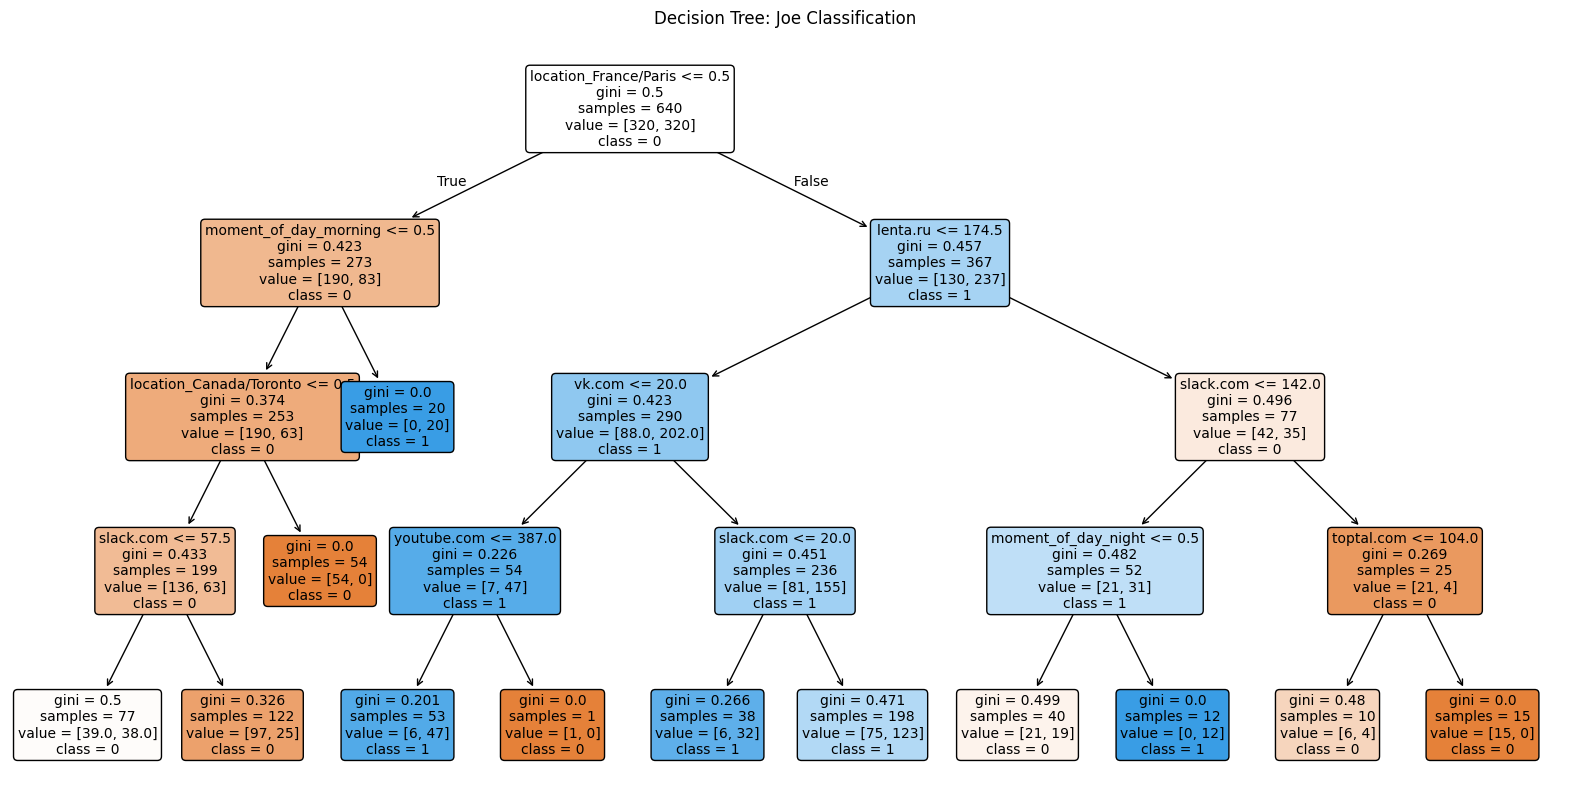

In [62]:
plt.figure(figsize=(20,10))
plot_tree(dt_clf, 
          feature_names=X.columns, 
          class_names=['0', '1'], 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("Decision Tree: Joe Classification")
plt.show()

In [63]:
## Trying to enhance model performance by using cross-validation
dt_clf_cv = DecisionTreeClassifier(max_depth=4, class_weight='balanced', random_state=42)
scores = cross_val_score(dt_clf_cv, X, y, cv=5)
scores

array([0.6875 , 0.59375, 0.69375, 0.74375, 0.675  ])

In [64]:
scores.mean()

np.float64(0.67875)

In [65]:
scores.std()

np.float64(0.04850901977983064)

<font size="5"> VALIDATION </font> 

In [68]:
with open('C:/Users/Valentin Villanueva/Downloads/usersessions/verify.json', 'r') as f:
    val_data = json.load(f)

In [71]:
val_df = pd.json_normalize(
    val_data, 
    record_path=['sites'], 
    meta=['browser', 'os', 'locale', 'gender', 'location', 'time', 'date'])
val_df

,site,length,browser,os,locale,gender,location,time,date
0,mail.google.com,383,Chrome,Ubuntu,ru_RU,m,Canada/Toronto,16:59:00,2017-09-05
1,vk.com,108,Chrome,Ubuntu,ru_RU,m,Canada/Toronto,16:59:00,2017-09-05
2,toptal.com,138,Chrome,Ubuntu,ru_RU,m,Canada/Toronto,16:59:00,2017-09-05
3,lenta.ru,47,Chrome,Ubuntu,ru_RU,m,Canada/Toronto,16:59:00,2017-09-05
4,slack.com,93,Chrome,Ubuntu,ru_RU,m,Canada/Toronto,16:59:00,2017-09-05
...,...,...,...,...,...,...,...,...,...
187981,kejet.net,405,Internet Explorer,Windows 10,ro-RO,m,USA/New York,17:31:00,2018-02-14
187982,digicert.com,83,Firefox,Windows 7,en-CA,m,USA/New York,16:51:00,2018-02-15
187983,toptal.com,103,Firefox,Windows 7,en-CA,m,USA/New York,16:51:00,2018-02-15
187984,youtube.com,119,Firefox,Windows 7,en-CA,m,USA/New York,16:51:00,2018-02-15


DATA PREPARATION : PIPELINE

In [72]:
## Generating an id to identify every session.
session_cols = ['browser', 'os', 'locale', 'location', 'time', 'date']
unique_sessions = val_df[session_cols].drop_duplicates().copy()
unique_sessions['session_id'] = [str(uuid.uuid4()) for _ in range(len(unique_sessions))]
val_df = val_df.merge(unique_sessions, on=session_cols, how='left')

## We want to clean our data before our model training. We will define a new feature called
## "moment of day" which states in which moment of the day the session was made.
def moment(hour):
    if 6 <= hour < 13:
        return 'morning'
    elif 13 <= hour < 20:
        return 'afternoon'
    else:
        return 'night'

val_df['hour'] = pd.to_datetime(val_df['time'], format='%H:%M:%S').dt.hour
val_df['moment_of_day'] =val_df['hour'].apply(moment)

interest_sites = ["lenta.ru", "toptal.com", "vk.com", "slack.com", "mail.google.com", "youtube.com"]

df_use = val_df.pivot_table(
    index=['session_id', 'browser', 'os', 'locale', 'gender', 'location', 'moment_of_day'],
    columns='site',
    values='length',
    aggfunc='sum'
).reset_index()

# Cleaning and filtering (final)
for site in interest_sites:
    if site not in df_use.columns:
        df_use[site] = 0

final_cols = ['session_id', 'browser', 'os', 'locale', 'gender', 'location', 'moment_of_day'] + interest_sites
df_val_final = df_use[final_cols].fillna(0)

In [ ]:
#### FILTERING NEEDED???? 
locations_ok = ['France/Paris', 'USA/Chicago', 'Canada/Toronto']
os_ok = ['Windows 10', 'Ubuntu']

# apply a filter, just relevant data to classify Joe
df_op = df_val_final[
    (df_val_final['location'].isin(locations_ok)) & 
    (df_val_final['os'].isin(os_ok)) &
    (df_val_final['locale'] == 'ru_RU')
].copy()  

### if  needed change df val final with df op

In [77]:
### feature selection  
features_val = df_val_final.drop(columns=[ "session_id"])
features_val

site,browser,os,locale,gender,location,moment_of_day,lenta.ru,toptal.com,vk.com,slack.com,mail.google.com,youtube.com
0,Firefox,Windows 10,ru_RU,m,Spain/Madrid,night,84.0,128.0,108.0,219.0,144.0,208.0
1,Firefox,Windows 10,nl-NL,f,Japan/Tokyo,night,0.0,0.0,0.0,0.0,64.0,196.0
2,Chrome,Windows 10,de-DE,m,UK/London,morning,0.0,103.0,0.0,200.0,0.0,0.0
3,Chrome,Ubuntu,ru_RU,m,Australia/Sydney,night,62.0,189.0,48.0,76.0,87.0,132.0
4,Firefox,Windows 7,en-SG,m,India/Delhi,afternoon,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
22695,Chrome,Windows 10,ru_RU,m,Australia/Sydney,morning,104.0,104.0,152.0,0.0,83.0,85.0
22696,Firefox,Ubuntu,ru_RU,m,Australia/Sydney,morning,72.0,42.0,294.0,524.0,122.0,42.0
22697,Firefox,Windows 8,uk-UA,m,France/Paris,night,57.0,0.0,0.0,98.0,0.0,0.0
22698,Internet Explorer,Windows 10,en-AU,f,Canada/Toronto,night,0.0,0.0,0.0,0.0,0.0,137.0


In [74]:
#compare to features (from x_train data) to see if columns match
features.columns

Index(['browser', 'os', 'locale', 'gender', 'location', 'moment_of_day',
       'lenta.ru', 'toptal.com', 'vk.com', 'slack.com', 'mail.google.com',
       'youtube.com', 'target'],
      dtype='object', name='site')

In [78]:
## feature encoding
cat_cols = ['browser', 'os', 'locale', 'gender', 'location', 'moment_of_day']

val_final_model = pd.get_dummies(features_val, columns=cat_cols)
val_final_model

,lenta.ru,toptal.com,vk.com,slack.com,mail.google.com,youtube.com,browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Safari,...,location_Singapore/Singapore,location_Spain/Madrid,location_UK/London,location_USA/Chicago,location_USA/Miami,location_USA/New York,location_USA/San Francisco,moment_of_day_afternoon,moment_of_day_morning,moment_of_day_night
0,84.0,128.0,108.0,219.0,144.0,208.0,False,True,False,False,...,False,True,False,False,False,False,False,False,False,True
1,0.0,0.0,0.0,0.0,64.0,196.0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,0.0,103.0,0.0,200.0,0.0,0.0,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
3,62.0,189.0,48.0,76.0,87.0,132.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22695,104.0,104.0,152.0,0.0,83.0,85.0,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
22696,72.0,42.0,294.0,524.0,122.0,42.0,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
22697,57.0,0.0,0.0,98.0,0.0,0.0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
22698,0.0,0.0,0.0,0.0,0.0,137.0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
